# Model template file

## 1. Import packages

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models

##  2. Displaying parameters, label files and images

Read in the train and test CSVs first and see what they look like.

In [4]:
# train_features = pd.read_csv("../data/train_features.csv", index_col="id")
# train_features['filepath'] = '../data/'+train_features.filepath
# test_features = pd.read_csv("../data/test_features.csv", index_col="id")
# test_features['filepath'] = '../data/'+test_features.filepath
# train_labels = pd.read_csv("../data/train_labels.csv", index_col="id")

# Convert 'value' column to appropriate data types
def convert_value(value):
    try:
        return int(value)
    except ValueError:
        try:
            return float(value)
        except ValueError:
            return value  # Return as string if it can't be converted to number

param_path = '../data/temp/parameters.csv'

if os.path.exists(param_path):
    df_param = pd.read_csv(param_path)
    df_param.set_index('parameter', inplace=True)
    # Apply the conversion function to the 'value' column
    df_param['value'] = df_param['value'].apply(convert_value)
    param = df_param.to_dict()['value']

else:
    param = {}

    # if we want to try one part of our dataset
    param['frac'] = 0.1 
    param['random_state'] = 1 
    
    param['data_folder'] = '../data' # if this file and folders train_features and test_features are in the same folder use '.'
    
    param['label_csv'] = os.path.join(param['data_folder'], 'train_labels.csv')
    param['train_features_csv'] = os.path.join(param['data_folder'], 'train_features.csv')
    
    param['test_features_csv'] = os.path.join(param['data_folder'], 'test_features.csv')
    param['results_csv_path'] = os.path.join(param['data_folder'], 'test_predictions.csv')
    

    # Convert dictionary to DataFrame with parameters as index and save to csv
    df_param = pd.DataFrame(list(param.items()), columns=['parameter', 'value']).set_index('parameter')



# Create variables and assign values
for key, value in param.items():
    globals()[key] = value
print(df_param)

                                                         value
parameter                                                     
frac                                                       0.1
random_state                                                42
use_white_line_cropping                                   True
use_logo_cropping                                         True
use_padding                                              False
channels_number                                              1
use_augmentation                                         False
low_classes                                    ['bird', 'hog']
data_folder                                            ../data
temp_folder                                       ../data/temp
input_train_folder                      ../data/train_features
input_test_folder                        ../data/test_features
label_csv                             ../data/train_labels.csv
train_features_csv                  ../data/train_featu

In [5]:
if os.path.exists(param_path):
    # if we already split our dataset to train and validation parts, we use these dataframes only to see the data (only train part of train_features)
    train_labels = pd.read_csv(output_train_label_csv, index_col="id") 
    train_features = pd.read_csv(output_train_features_csv, index_col="id")
    test_features = pd.read_csv(output_test_features_csv, index_col="id")

    # we are creating here our train and validation datasets for our model because we have them preprocessed
    x_train = pd.read_csv(output_train_features_csv, index_col="id").filepath.to_frame()
    x_eval = pd.read_csv(output_val_features_csv, index_col="id").filepath.to_frame()
    y_train = pd.read_csv(output_train_label_csv, index_col="id")
    y_eval = pd.read_csv(output_val_label_csv, index_col="id")

else:
    # if we did nothing in preprocessing.ipynb and don't have any preprocessed pictures and any file of parameters, we are taking initial pictures and will split them later
    train_labels = pd.read_csv(label_csv, index_col="id")
    train_features = pd.read_csv(train_features_csv, index_col="id")
    test_features = pd.read_csv(test_features_csv, index_col="id")

    train_features['filepath'] = data_folder+'/'+train_features.filepath
    test_features['filepath'] = data_folder+'/'+test_features.filepath

The `features` CSVs contain the image ID, filepath and site ID for each image. 

In [6]:
train_features.head()

filepath   site
id                                                      
ZJ009932  ../data/temp/train_and_val/ZJ009932.jpg  S0038
ZJ000084  ../data/temp/train_and_val/ZJ000084.jpg  S0159
ZJ005333  ../data/temp/train_and_val/ZJ005333.jpg  S0141
ZJ005386  ../data/temp/train_and_val/ZJ005386.jpg  S0036
ZJ015367  ../data/temp/train_and_val/ZJ015367.jpg  S0023

In [7]:
test_features.head()

filepath   site
id                                             
ZJ016488  ../data/temp/test/ZJ016488.jpg  S0082
ZJ016489  ../data/temp/test/ZJ016489.jpg  S0040
ZJ016490  ../data/temp/test/ZJ016490.jpg  S0040
ZJ016491  ../data/temp/test/ZJ016491.jpg  S0041
ZJ016492  ../data/temp/test/ZJ016492.jpg  S0040

The `train_labels` CSV is an indicator matrix of the species identified in each of the training images. Some images are labeled as "blank" if no animal was detected.

In [8]:
train_labels.head()

antelope_duiker  bird  blank  civet_genet  hog  leopard   
id                                                                  
ZJ009932              0.0   0.0    0.0          0.0  0.0      1.0  \
ZJ000084              0.0   0.0    1.0          0.0  0.0      0.0   
ZJ005333              1.0   0.0    0.0          0.0  0.0      0.0   
ZJ005386              0.0   0.0    0.0          0.0  0.0      0.0   
ZJ015367              1.0   0.0    0.0          0.0  0.0      0.0   

          monkey_prosimian  rodent  
id                                  
ZJ009932               0.0     0.0  
ZJ000084               0.0     0.0  
ZJ005333               0.0     0.0  
ZJ005386               1.0     0.0  
ZJ015367               0.0     0.0

Let's store a sorted list of the labels, so that we can sort the inputs and outputs to our model in a consistent way.

In [9]:
species_labels = sorted(train_labels.columns.unique())
species_labels

['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'leopard',
 'monkey_prosimian',
 'rodent']

Now let's see what some of the actual images look like. The code below iterates through a list of species and selects a single random image from each species to display, along with its image ID and label. You can try changing the `random_state` variable to display a new set of images.

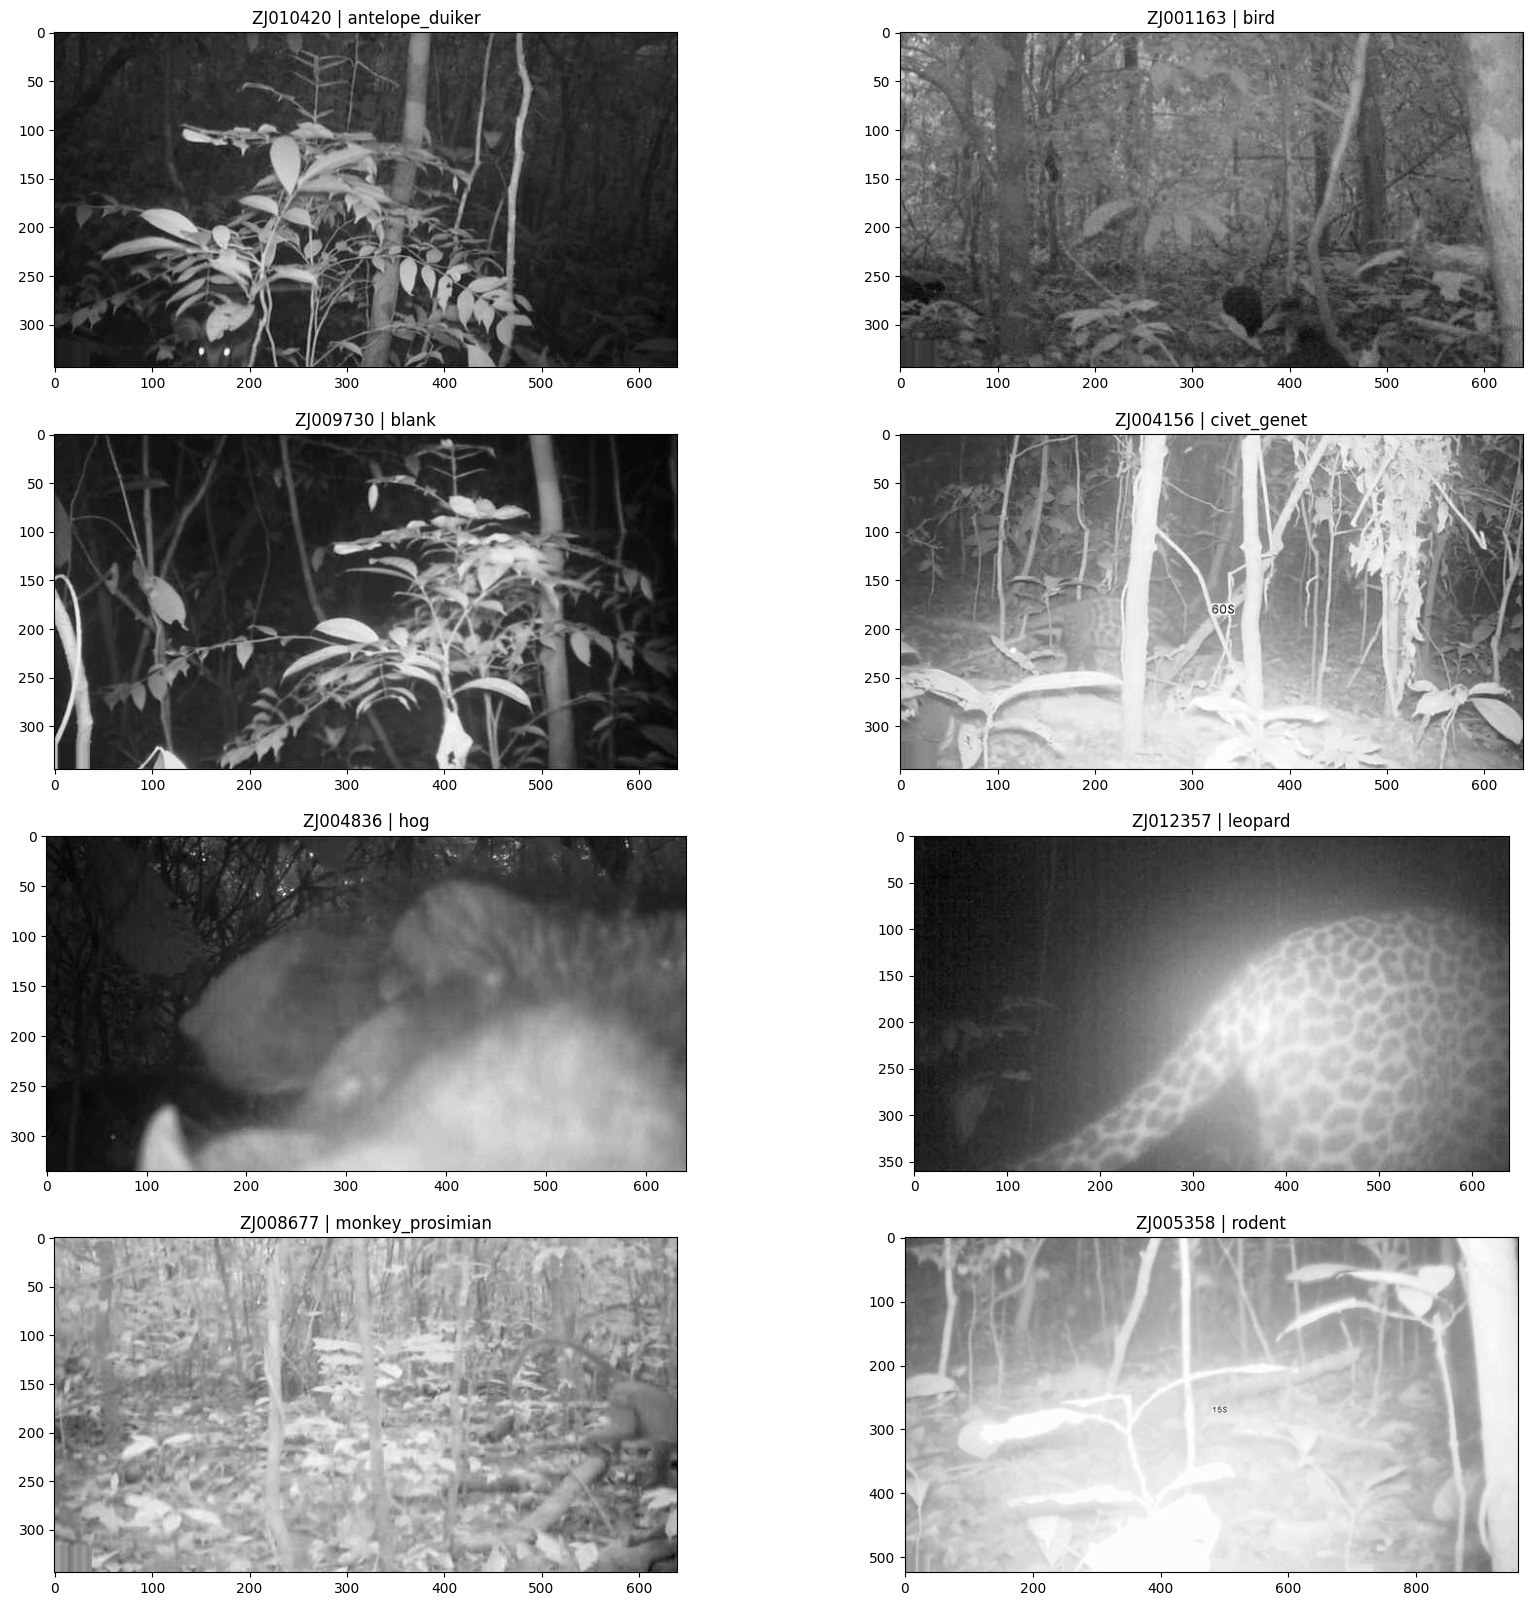

In [10]:


random_state = 42

# we'll create a grid with 8 positions, one for each label (7 species, plus blanks)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))

# iterate through each species
for species, ax in zip(species_labels, axes.flat):
    # get an image ID for this species
    img_id = (
        train_labels[train_labels.loc[:,species] == 1]
        .sample(1, random_state=random_state)
        .index[0]
    )
    # reads the filepath and returns a numpy array
    img = mpimg.imread(train_features.loc[img_id].filepath)
    # plot etc
    ax.imshow(img, cmap='gray')
    ax.set_title(f"{img_id} | {species}")

Can you spot the animals? I'm still not sure where the rodent is. Birds can be tough to spot too.

Let's look at the distribution of species across the training set, first in terms of overall counts and then in percentage terms.

In [11]:
train_labels.sum().sort_values(ascending=False)

monkey_prosimian    196.0
antelope_duiker     186.0
blank               179.0
civet_genet         163.0
rodent              154.0
leopard             149.0
bird                137.0
hog                  72.0
dtype: float64

In [12]:
train_labels.sum().divide(train_labels.shape[0]).sort_values(ascending=False)

monkey_prosimian    0.158576
antelope_duiker     0.150485
blank               0.144822
civet_genet         0.131877
rodent              0.124595
leopard             0.120550
bird                0.110841
hog                 0.058252
dtype: float64

In case you're curious, this distribution is not exactly what we find in the wild. The competition dataset has been curated a little bit to produce a more uniform distribution than we would see in the actual data.

There's a lot more data exploration to do. For example, you might also want to look at the distribution of image dimensions or camera trap sites. But since our primary goal here is to develop a benchmark, let's move on to the modeling!

## 3. Create train and evaluation sets
First, we'll need to split the images into train and eval sets. We'll put aside 25% of the data for evaluation and stratify by the target labels to ensure we have similar relative frequencies of each class in the train and eval sets.

For the purposes of this benchmark, we're also going to limit ourselves to a 50% subset of the training data, just so that things run faster. But feel free to adjust `frac` or remove it entirely if you want to run the training on the full set.

In [13]:
# from sklearn.model_selection import train_test_split

# frac = 0.5

# y = train_labels.sample(frac=frac, random_state=1)
# x = train_features.loc[y.index].filepath.to_frame()

# # note that we are casting the species labels to an indicator/dummy matrix
# x_train, x_eval, y_train, y_eval = train_test_split(
#     x, y, stratify=y, test_size=0.25
# )

if os.path.exists(param_path) == False:

    y = train_labels.sample(frac=frac, random_state=1)
    x = train_features.loc[y.index].filepath.to_frame()

    # note that we are casting the species labels to an indicator/dummy matrix
    x_train, x_eval, y_train, y_eval = train_test_split(
        x, y, stratify=y, test_size=0.25
    )

Here's what `x_train` and `y_train` look like now:

In [14]:
x_train.head()

filepath
id                                               
ZJ009932  ../data/temp/train_and_val/ZJ009932.jpg
ZJ000084  ../data/temp/train_and_val/ZJ000084.jpg
ZJ005333  ../data/temp/train_and_val/ZJ005333.jpg
ZJ005386  ../data/temp/train_and_val/ZJ005386.jpg
ZJ015367  ../data/temp/train_and_val/ZJ015367.jpg

In [15]:
y_train.head()

antelope_duiker  bird  blank  civet_genet  hog  leopard   
id                                                                  
ZJ009932              0.0   0.0    0.0          0.0  0.0      1.0  \
ZJ000084              0.0   0.0    1.0          0.0  0.0      0.0   
ZJ005333              1.0   0.0    0.0          0.0  0.0      0.0   
ZJ005386              0.0   0.0    0.0          0.0  0.0      0.0   
ZJ015367              1.0   0.0    0.0          0.0  0.0      0.0   

          monkey_prosimian  rodent  
id                                  
ZJ009932               0.0     0.0  
ZJ000084               0.0     0.0  
ZJ005333               0.0     0.0  
ZJ005386               1.0     0.0  
ZJ015367               0.0     0.0

In [16]:
x_train.shape, y_train.shape, x_eval.shape, y_eval.shape

((1236, 1), (1236, 8), (413, 1), (413, 8))

Next, let's validate that our split has resulted in roughly similar relative distributions of species across the train and eval sets (because of how we passed `stratify=y` above).

In [17]:
split_pcts = pd.DataFrame(
    {
        "train": y_train.idxmax(axis=1).value_counts(normalize=True),
        "eval": y_eval.idxmax(axis=1).value_counts(normalize=True),
    }
)
print("Species percentages by split")
(split_pcts.fillna(0) * 100).astype(int)

Species percentages by split


train  eval
monkey_prosimian     15    15
antelope_duiker      15    15
blank                14    14
civet_genet          13    13
rodent               12    12
leopard              12    12
bird                 11    11
hog                   5     5

Good, this looks as expected.

### The Dataset

First, we'll create an `ImagesDataset` class that will define how we access our data and any transformations we might want to apply. 

This new class will inherit from the PyTorch [`Dataset`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) class, but we'll also need to define our own `__init__`, `__len__` and `__getitem__` **special methods**:
* **`__init__`** will instantiate the dataset object with two dataframes: an `x_train` df containing image IDs and image file paths, and a `y_train` df containing image IDs and labels. This will run once when we first create the dataset object, e.g. with `dataset = ImagesDataset(x_train, y_train)`.
* **`__getitem__`** will define how we access a sample from the data. This method gets called whenever we use an indexing operation like `dataset[index]`. In this case, whenever accessing a particular image sample (for example, to get the first image we'd do `dataset[0]`) the following will happen:
  * look up the image filepath using the index
  * load the image with [`PIL.Image`](https://pillow.readthedocs.io/en/stable/reference/Image.html)
  * apply some transformations (more on this below)
  * return a dictionary containing the image ID, the image itself as a Tensor, and a label (if it exists)
* **`__len__`** simply returns the size of the dataset, which we do by calling `len` on the input dataframe.

In [18]:
class ImagesDataset(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """

    def __init__(self, x_df, y_df=None):
        self.data = x_df
        self.label = y_df
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                ),
            ]
        )

    def __getitem__(self, index):
        image = Image.open(self.data.iloc[index]["filepath"]).convert("RGB")
        image = self.transform(image)
        image_id = self.data.index[index]
        # if we don't have labels (e.g. for test set) just return the image and image id
        if self.label is None:
            sample = {"image_id": image_id, "image": image}
        else:
            label = torch.tensor(self.label.iloc[index].values, 
                                 dtype=torch.float)
            sample = {"image_id": image_id, "image": image, "label": label}
        return sample

    def __len__(self):
        return len(self.data)

Notice that we are also defining a set of **transformations**, which are defined in the `__init__` and called in the `__getitem__` special methods. These are applied to each image before returning it. Here's what each of those transformations do and why:

* `transforms.Resize((224, 224))` ResNet50 was trained on images of size 224x224 so we resize to the same dimensions here. See [pytorch docs](https://pytorch.org/vision/stable/models.html) and the [ResNet paper](https://arxiv.org/pdf/1512.03385.pdf).
* `transforms.ToTensor()` converts the image to a tensor. Since we are passing in a PIL Image at this point, PyTorch can recognize it as an RGB image and will automatically convert the input values which are in the range [0, 255] to a range of [0, 1]. See more from the [PyTorch docs](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html).
* `transforms.Normalize(...)` normalizes the image tensors using the mean and standard deviation of ImageNet images. Because this transformation was applied to images when training the ResNet model, we want to do the same here with our images. See more from the [PyTorch docs on pretrained models](https://pytorch.org/vision/stable/models.html).

### The DataLoader
Next, we need to load the dataset into a dataloader. The `DataLoader` class lets us iterate through our dataset in batches.

## 4. Building and training the model
Now it's time to start building our model and then training it.

We'll use a pretrained ResNet50 model as our backbone. ResNets are one of the more popular networks for image classification tasks. The pretrained model outputs a 2048-dimension embedding, which we will then connect to two more dense layers, with a ReLU and Dropout step in between. 

These final layers, defined in `model.fc`, are the new "head" of our model, and allow us to transform the image embeddings produced by the pretrained "backbone" into the 8-dimensional output required to learn the species classification task we're tackling here. Prior to redefining it below, `model.fc` would be the final, dense layer connecting the 2048-dimension embedding to a 1000-dimension output (corresponding to the 1000 ImageNet classes that the pretrained model was trained on). We will instead prepare the model for the current task by redefining `model.fc` to produce an 8-dimensional output corresponding to our 8 species classes (including blanks). 

We'll also add a couple more layers in between. The `ReLU` layer introduces non-linearity into the model head, in effect activating important features and suppressing noise. And the `Dropout` layer is a commonly used regularization component that randomly drops some nodes from the previous layer's outputs (10% of nodes in this case) during each training step, mitigating our risk of overfitting.

In [19]:
train_dataset = ImagesDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32)

In [20]:
eval_dataset = ImagesDataset(x_eval, y_eval)
eval_dataloader = DataLoader(eval_dataset, batch_size=32)

The data pieces are now largely in place!

In [21]:
model = models.resnet50(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(2048, 100),  # dense layer takes a 2048-dim input and outputs 100-dim
    nn.ReLU(inplace=True),  # ReLU activation introduces non-linearity
    nn.Dropout(0.1),  # common technique to mitigate overfitting
    nn.Linear(
        100, 8
    ),  # final dense layer outputs 8-dim corresponding to our target classes
)

/Users/tetyanasamoylenko/Desktop/neuefische/ds-capstone-project/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/tetyanasamoylenko/Desktop/neuefische/ds-capstone-project/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


***device switches to GPU if it is available. Else, it will use CPU.***

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

### Define our loss function
Cross entropy loss (or log loss) is a commonly used loss function for multi-class (not multi-label) image classification. We'll use this to compute loss for each training batch and then update our parameters accordingly. 

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Train the model
We're now ready to train our model!

We'll start simple and just run it for one epoch, but feel free to run it for more `num_epochs` if you've got the time. We hope to see a decreasing loss as training progresses, which will provide some evidence that the model is learning. Note that we haven't frozen any weights in the pretrained model, a choice which you may want to revisit and we discuss in a little more detail below.

For each epoch we'll iterate through the batches, and for each batch we'll do the following:
1. Zero out the gradients. PyTorch will sum the gradients from past batches when doing its backward pass, so in order to make sure we are only using the gradients computed for the current batch, we zero out the gradients at the beginning of each batch.
2. Run the forward pass.
3. Compute the loss and track it.
4. Compute our gradients and update our weight parameters.

In [24]:
num_epochs = 10

# create empty dictionaries for train and validation loss
train_loss = {}
val_loss = {}

for epoch in range(1, num_epochs + 1):
    print(f"Starting epoch {epoch}")

    # put model in train mode
    model.train()

    # create running_train_loss variable
    running_train_loss = 0.0

    # iterate through the dataloader batches. tqdm keeps track of progress.
    for batch_n, batch in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):
        images = batch['image'].to(device)
        labels = batch['label'].to(device)
        
        # 1) zero out the parameter gradients so that gradients from previous batches are not used in this step
        optimizer.zero_grad()
        
        # 2) run the foward step on this batch of images
        outputs = model(images)

        # 3) compute the loss
        loss = criterion(outputs, labels)
        # let's keep track of the loss by epoch and batch
        train_loss[(epoch, batch_n)] = loss.item()
        # Lets also track the running train loss per epoch
        running_train_loss += loss.item()

        # 4) compute our gradients
        loss.backward()
        # update our weights
        optimizer.step()
    
    # put model in evaluation mode
    model.eval()

    # create running val loss variable
    running_val_loss = 0.0

    with torch.no_grad():           # turned off gradient computing to save memory and computations
        for batch_n_val, batch_val in tqdm(enumerate(eval_dataloader), total=len(eval_dataloader)): # this is pretty much the same as above, but without all training functions
            
            # 1) get images and labels from validation set dataloader
            images_val = batch_val['image'].to(device)
            labels_val = batch_val['label'].to(device)

            # 2) get model's output for val. images, calculate loss, save it and add it to the running loss
            val_outputs = model(images_val)
            loss = criterion(val_outputs, labels_val)
            val_loss[(epoch, batch_n_val)] = loss.item()
            running_val_loss += loss.item()
    
    epoch_train_loss = running_train_loss / len(train_dataloader)
    epoch_val_loss = running_val_loss / len(eval_dataloader)

    print(f"Epoch {epoch} - Train Loss: {epoch_train_loss:.5f}, Val. Loss: {epoch_val_loss:.5f}")



Starting epoch 1


100%|██████████| 13/13 [00:42<00:00,  3.27s/it]


Here I should implement changing back to CPU if necessary.

In [25]:
model.cpu()

images.cpu()
labels.cpu()
images_val.cpu()
labels_val.cpu()
loss.cpu()
outputs.cpu()
val_outputs.cpu()

torch.cuda.empty_cache()

## 5. Evaluation

Now let's plot the loss by epoch and batch. The x-axis here is a tuple of `(epoch, batch)`.

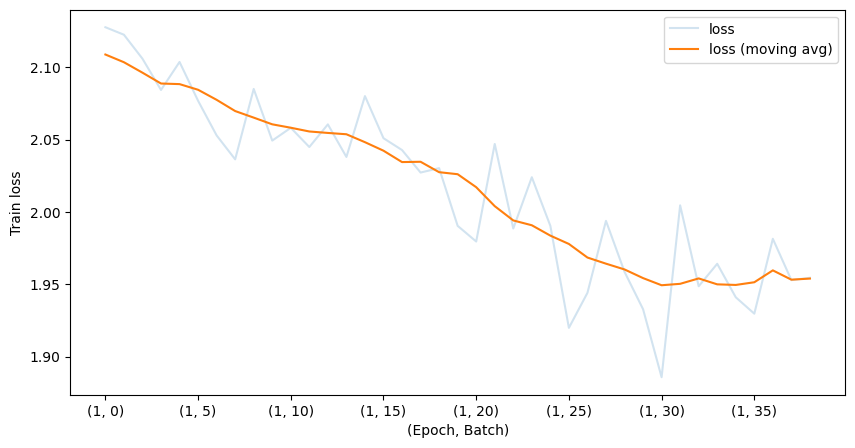

In [26]:
train_loss = pd.Series(train_loss)

plt.figure(figsize=(10, 5))
train_loss.plot(alpha=0.2, label="loss")
train_loss.rolling(center=True, min_periods=1, window=10).mean().plot(
    label="loss (moving avg)"
)
plt.xlabel("(Epoch, Batch)")
plt.ylabel("Train loss")
plt.legend(loc=0)

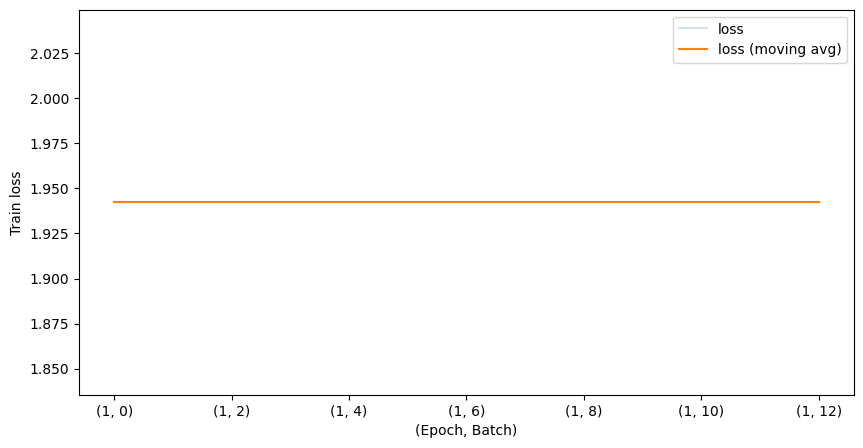

In [27]:
val_loss = pd.Series(val_loss)

plt.figure(figsize=(10, 5))
val_loss.plot(alpha=0.2, label="loss")
val_loss.rolling(center=True, min_periods=1, window=10).mean().plot(
    label="loss (moving avg)"
)
plt.xlabel("(Epoch, Batch)")
plt.ylabel("Val loss")
plt.legend(loc=0)

Good news, the loss is going down! This is an encouraging start, especially since we haven't done anything fancy yet.

### Save the model
We have the model loaded in memory already, so we don't really need to save the model, but it's often useful to do this so we can use it again later. 

Here's how:

In [29]:
#torch.save(model, "model.pth")

So far, not so bad. We've shown an improvement in the loss on the training set, but that tells us little about how our model will do on new data. Let's reload our saved model and try generating some predictions on the evaluation split we created earlier.

In [30]:
#loaded_model = torch.load("model.pth")

We create the eval dataset and dataloader just like we did earlier with the training dataset and dataloader:

### Make predictions
We'll iterate through the eval dataloader in batches, just like we did for training, but this time we aren't going to need to compute gradients or update weights. For each batch, we'll do the following:
1. Run the forward pass to get the model output or logits
2. Apply a softmax function to convert the logits into probability space with range[0,1]. During training, the softmax operation was handled internally by `nn.CrossEntropyLoss`. We aren't computing the loss now because we are just doing evaluation, but we still want the predictions to be in the range[0,1]. 
3. Store the results in a dataframe for further analysis

In [31]:
preds_collector = []

# put the model in eval mode so we don't update any parameters
model.eval()

# we aren't updating our weights so no need to calculate gradients
with torch.no_grad():
    for batch in tqdm(eval_dataloader, total=len(eval_dataloader)):
        # 1) run the forward step
        logits = model.forward(batch["image"])
        # 2) apply softmax so that model outputs are in range [0,1]
        preds = nn.functional.softmax(logits, dim=1)
        # 3) store this batch's predictions in df
        # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
        preds_df = pd.DataFrame(
            preds.detach().numpy(),
            index=batch["image_id"],
            columns=species_labels,
        )
        preds_collector.append(preds_df)

eval_preds_df = pd.concat(preds_collector)
eval_preds_df

100%|██████████| 13/13 [01:04<00:00,  5.00s/it]


antelope_duiker      bird     blank  civet_genet       hog   
ZJ001768         0.139856  0.098556  0.134974     0.138373  0.073815  \
ZJ005134         0.153558  0.111426  0.157738     0.098760  0.055613   
ZJ011843         0.130531  0.098115  0.120474     0.197217  0.069302   
ZJ000357         0.164886  0.113317  0.147883     0.109814  0.066577   
ZJ004614         0.111629  0.081421  0.106199     0.282615  0.055867   
...                   ...       ...       ...          ...       ...   
ZJ015400         0.143696  0.091027  0.142242     0.205787  0.056230   
ZJ009494         0.157646  0.134993  0.156099     0.097407  0.061798   
ZJ008379         0.141047  0.099557  0.124346     0.209966  0.054314   
ZJ003204         0.142728  0.084572  0.136766     0.236965  0.052077   
ZJ002718         0.158995  0.108652  0.151819     0.118291  0.063305   

           leopard  monkey_prosimian    rodent  
ZJ001768  0.149417          0.149678  0.115331  
ZJ005134  0.110391          0.203037  0.109477  
ZJ011843  0.116396          0.131163  0.136803  
ZJ000357  0.107178          0.180603  0.109742  
ZJ004614  0.115169          0.100661  0.146437  
...            ...               ...       ...  
ZJ015400  0.103389          0.126239  0.131392  
ZJ009494  0.112492          0.184576  0.094989  
ZJ008379  0.119155          0.116536  0.135080  
ZJ003204  0.101158          0.112817  0.132917  
ZJ002718  0.102582          0.183111  0.113247  

[413 rows x 8 columns]

### Predicted labels distribution
First let's review the species distribution we saw in the training set.

In [32]:
print("True labels (training):")
y_train.idxmax(axis=1).value_counts()

True labels (training):


monkey_prosimian    196
antelope_duiker     186
blank               179
civet_genet         163
rodent              154
leopard             149
bird                137
hog                  72
Name: count, dtype: int64

Here's the distribution of our predictions on the eval set. 

In [33]:
print("Predicted labels (eval):")
eval_preds_df.idxmax(axis=1).value_counts()

Predicted labels (eval):


monkey_prosimian    261
civet_genet         127
antelope_duiker      16
blank                 9
Name: count, dtype: int64

The actual evaluation set is more evenly distributed than our predictions, so we already know there is some room for improvement here.

In [34]:
print("True labels (eval):")
y_eval.idxmax(axis=1).value_counts()

True labels (eval):


monkey_prosimian    65
antelope_duiker     62
blank               60
civet_genet         55
rodent              51
leopard             50
bird                46
hog                 24
Name: count, dtype: int64

### Accuracy
Now let's compute how accurate our model is and compare that against some trivial baseline models. First let's get the labels with the highest score for each image.

In [35]:
eval_predictions = eval_preds_df.idxmax(axis=1)
eval_predictions.head()

ZJ001768    monkey_prosimian
ZJ005134    monkey_prosimian
ZJ011843         civet_genet
ZJ000357    monkey_prosimian
ZJ004614         civet_genet
dtype: object

Random guessing across 8 classes would yield an accuracy of 12.5% (1/8). But we could construct a slightly better trivial model by always guessing the most common class ("monkey_prosimian" images in this case).

If we were to always guess that an image is `monkey_prosimian`, we could achieve accuracy of 15.8%.

In [36]:
eval_true = y_eval.idxmax(axis=1)

(eval_true == "monkey_prosimian").sum() / len(eval_predictions)

0.15738498789346247

Let's see how our model compares. We take the species with the highest score for each image (`eval_predictions`) and compare that to the true labels.

In [37]:
correct = (eval_predictions == eval_true).sum()
accuracy = correct / len(eval_predictions)
accuracy

0.28329297820823246

Our accuracy on the evaluation set is about 50%, which is not a bad start for a very simple first pass and one epoch of training.

Let's look at the predictions from another angle. 

We can see from the confusion matrix below that our model does reasonably well on some species, but we have plenty of room for improvement on antelopes, birds, hogs and blanks.

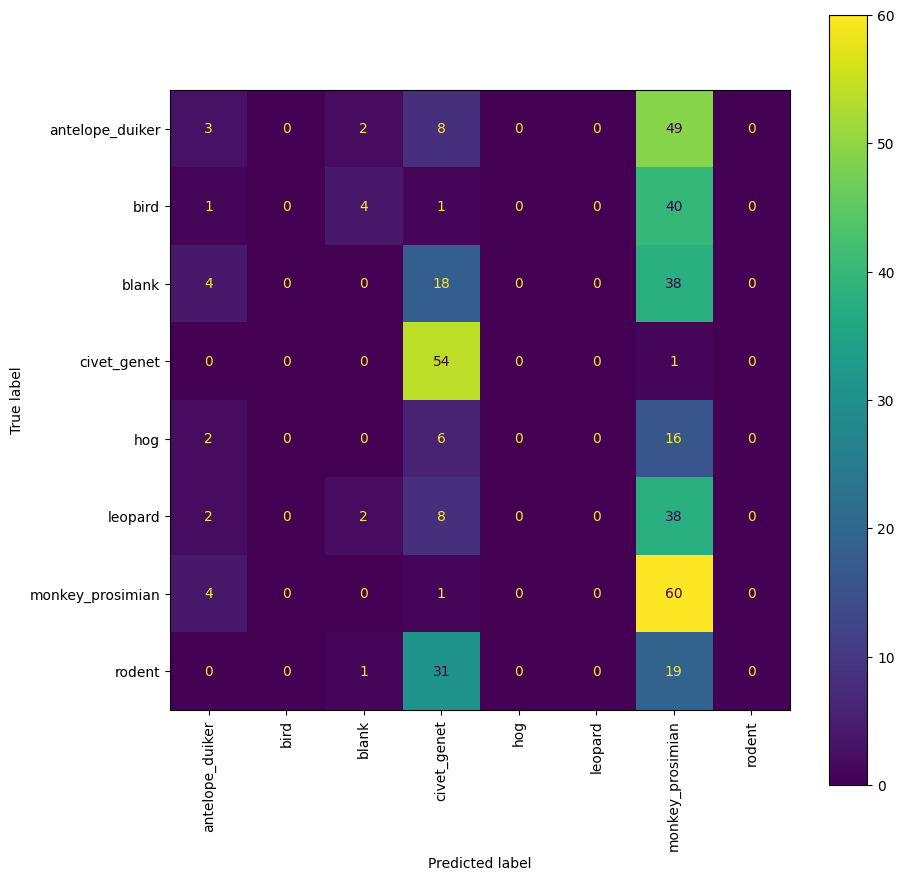

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
    y_eval.idxmax(axis=1),
    eval_preds_df.idxmax(axis=1),
    ax=ax,
    xticks_rotation=90,
    colorbar=True,
)

## Error analysis

In [ ]:
# ERROR ANALISYS
import shutil
# 1. Ensure indexes are the same
# Make sure the indexes of eval_preds_df and y_eval match
assert eval_preds_df.index.equals(y_eval.index), "Indexes of eval_preds_df and y_eval do not match."
# 2. Find predicted labels
# Get the column with the highest probability for each row
predicted_labels = eval_preds_df.idxmax(axis=1)
# 3. Find actual labels
# For each row, find the column where the value is 1 (i.e., the actual label)
actual_labels = y_eval.idxmax(axis=1)
# 4. Compare predictions and actuals
# Create a boolean mask where predicted and actual labels differ
mismatch_mask = predicted_labels != actual_labels
# 5. Create error_df with only mismatched rows
error_df = pd.DataFrame({
    'predict': predicted_labels[mismatch_mask],
    'real': actual_labels[mismatch_mask]
}, index=mismatch_mask[mismatch_mask].index)
# Sort error_df by 'real' and then by 'predict'
error_df = error_df.sort_values(by=['real', 'predict'])
# Add filepath column
error_df['filepath'] = error_df.index.to_series().apply(lambda x: os.path.join(input_train_folder, f"{x}.jpg"))
# Set index name to 'id'
error_df.index.name = 'id'
def recreate_directory(directory):
    """Delete the directory if it exists and recreate it."""
    if os.path.exists(directory):
        shutil.rmtree(directory)  # Remove the directory and all its contents
    os.makedirs(directory)  # Create a new empty directory
# Define the path for the error directory
errors_directory = os.path.join(data_folder, 'errors')
# Recreate the directory
recreate_directory(errors_directory)
# Save the error_df DataFrame to a CSV file in the errors directory
csv_file_path = os.path.join(errors_directory, 'error_df.csv')
error_df.to_csv(csv_file_path, index=True)
# Print the result (or save it to a file)
error_df

In [ ]:
# Save errors in the folder errors/pictures to analyze them
# Define the path for the error directory
errors_directory = os.path.join(param['data_folder'], 'errors')
csv_file_path = os.path.join(errors_directory, 'error_df.csv')
if os.path.exists(csv_file_path):
    error_df = pd.read_csv(csv_file_path)
def recreate_directory(directory):
    """Delete the directory if it exists and recreate it."""
    if os.path.exists(directory):
        shutil.rmtree(directory)  # Remove the directory and all its contents
    os.makedirs(directory)  # Create a new empty directory
# Define the path for the pictures directory
pictures_directory = os.path.join(errors_directory, 'pictures')
# Recreate the directory
recreate_directory(pictures_directory)
# Loop through the rows of the error_df DataFrame
for idx, row in error_df.iterrows():
    original_filepath = row['filepath']
    # Create new filename using the format 'id_real_predict.jpg'
    new_filename = f"{row['id']}__{row['real']}__{row['predict']}.jpg"
    new_filepath = os.path.join(pictures_directory, new_filename)
    # Rename the image file and copy to error folder
    shutil.copy(original_filepath, new_filepath)

In [ ]:
# Initialize the counter
counter = 0

In [ ]:

def display_images(error_df, counter, batch_size=12):
    # Define the range of indices to display
    start_idx = counter
    end_idx = min(counter + batch_size, len(error_df))
    # Slice the DataFrame to get the current batch
    batch_df = error_df.iloc[start_idx:end_idx]
    # Display images
    plt.figure(figsize=(15, 10))
    for i, (idx, row) in enumerate(batch_df.iterrows()):
        image = Image.open(row['filepath'])
        plt.subplot(3, 4, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Real: {row['real']}, Predict: {row['predict']}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
# Update the counter for the next batch
counter += 12
# Display the current batch of images
display_images(error_df, counter)